In [78]:
# Add root folder to python path
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

# Add some common packages
import numpy as np
import pandas as pd
import math
import scipy.stats as ss
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

import plotly.express as px
from reliability.Fitters import Fit_Weibull_3P

In [79]:
# Set up the failure mode class
from pof.failure_mode import FailureMode
from pof.condition import Condition

fm = FailureMode(alpha=50, beta=1.5, gamma=20)

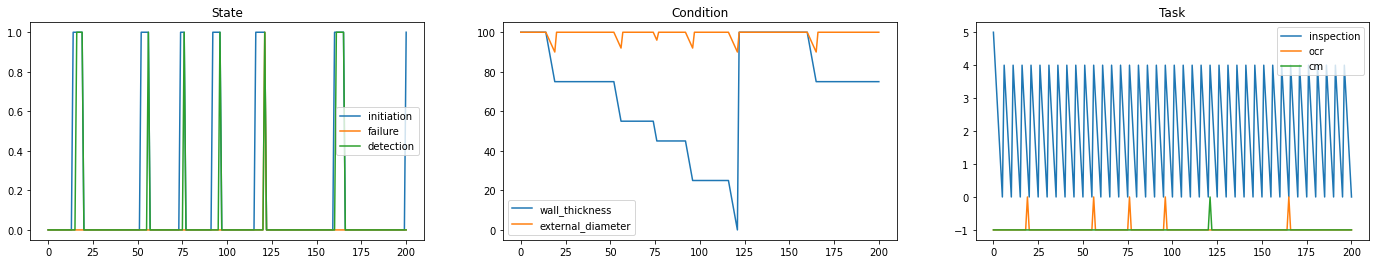

In [80]:
timeline = fm.sim_timeline(200, verbose=False)
fm.plot_timeline()

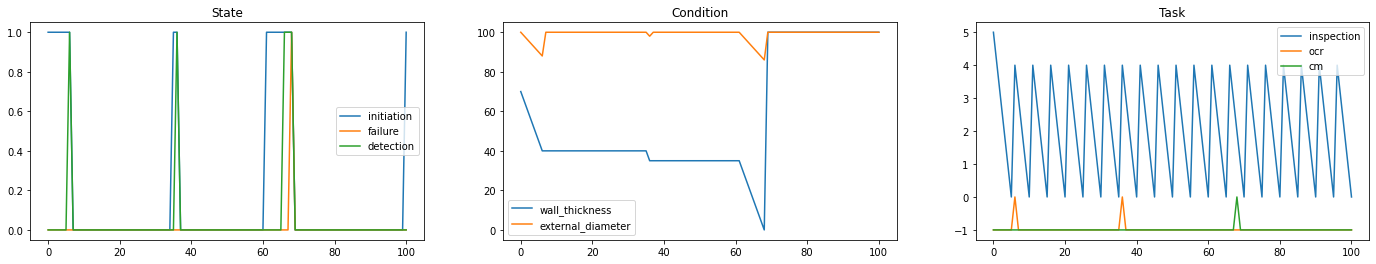

In [81]:
fm._initiated = True
fm.conditions['wall_thickness'].set_condition(70)
#fm.conditions['wall_thickness'].set_condition_profile()
fm.sim_timeline(100)
fm.plot_timeline()

In [82]:
fm.mc_timeline(1000)

100%|██████████| 100/100 [00:05<00:00, 17.90it/s]


In [83]:
df = fm.expected_cost_df()

fig = px.area(df, x="time", y="cost_cumulative", color="task")
fig.show()

Results from Fit_Weibull_3P (95% CI):
           Point Estimate  Standard Error    Lower CI    Upper CI
Parameter                                                        
Alpha          163.251371        9.431550  145.774050  182.824105
Beta             1.819000        0.142241    1.560525    2.120287
Gamma           67.740231        8.628438   52.774551   86.949841
Log-Likelihood: -576.1231387850809


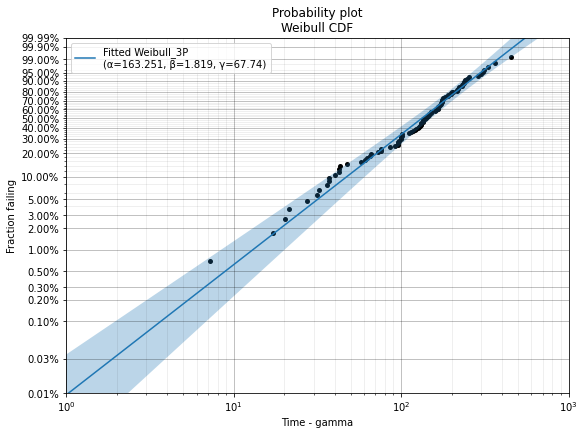

In [71]:
t_failures = []
for timeline in fm._timelines.values():
    t_failures = np.append(t_failures, np.argmax(timeline['failure']))

# Arange into failures and censored data
failures = t_failures[t_failures > 0]
censored = np.full(sum(t_failures==0), 200)

# Fit the Weibull
Fit_Weibull_3P(failures=failures, right_censored=censored)

In [72]:
n_iterations = 1000
t_end = 200
t_start = 0

fm2 = FailureMode(alpha=50, beta=1.5, gamma=20)
del fm2.tasks['ocr']

for i in tqdm(range(n_iterations)):

    fm2._timelines[i] = fm2.sim_timeline(t_end=t_end, t_start=t_start)

100%|██████████| 1000/1000 [00:10<00:00, 92.59it/s]


Results from Fit_Weibull_3P (95% CI):
           Point Estimate  Standard Error   Lower CI   Upper CI
Parameter                                                      
Alpha           48.969459        1.103858  46.853035  51.181486
Beta             1.475837        0.036758   1.405523   1.549669
Gamma           24.498604        0.344901  23.831852  25.184011
Log-Likelihood: -4682.513765966899


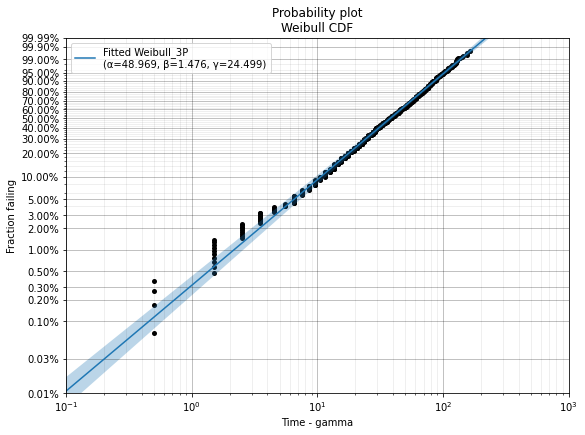

In [73]:
t_failures = []
for timeline in fm2._timelines.values():
    t_failures = np.append(t_failures, np.argmax(timeline['failure']))

# Arange into failures and censored data
failures = t_failures[t_failures > 0]
censored = np.full(sum(t_failures==0), 200)

# Fit the Weibull
Fit_Weibull_3P(failures=failures, right_censored=censored)

In [74]:
df2 = fm.mc_risk_df()

In [75]:
t_interval = dict()
risk = dict()
cost = dict()
fm.reset()

for i in range(1,10, 1):

    # Set t_interval
    fm.tasks['inspection'].t_interval = i
    
    fm.mc_timeline(t_end=100, n_iterations=1000)

    cost[i] = fm.expected_costs()
    cost[i]['inspection_interval'] = i

    # Reset fm

    fm.reset()

100%|██████████| 1000/1000 [00:03<00:00, 289.64it/s]


In [76]:
df_plot = pd.DataFrame(cost).T

df_plot = pd.melt(df_plot, id_vars=['inspection_interval'], var_name = 'source', value_name = 'cost')

fig = px.line(df_plot, x="inspection_interval", y="cost", color='source', title='Risk v Cost')
fig.show()

In [ ]:
# Tasks
scheduled_inspection = ScheduledInspection()
        #Repair - Change detection and initiation
        #Restoration - Change detection, initiation, failure and condition
        #Replacement - Change everything

on_condition_repair = OnConditionRepair()
on_condition_replacement = OnConditionReplacement()
        Repair - Change detection and initiation
        Restoration ...
        Repalcement

scheduled_inspection.set_params(
        t_interval = 5
        t_delay = 20
        p_effective = 0.9
        state_triggers = dict()
        condition_triggers = condition_triggers
        state_impacts = state_impacts
        condition_impacts = condition_impacts
)


# Failure Modes
early_life = FailureMode(alpha=10000, beta=0.5, gamma=0)
random = FailureMode(alpha=1000, beta=1, gamma=0)
slow_aging = FailureMode(alpha=100, beta=1.5, gamma=20),
fast_aging = FailureMode(alpha=50, beta=2, gamma=20),

fm3 = FailureMode(alpha=50, beta=1.5, gamma=20)

fm3.set_failure_dist(
    Distribution(alpha=50, beta=1.5, gamma=10)
)

fm3.set_conditions(dict(
    wall_thickness = Condition(100, 0, 'linear', [-5]),
    external_diameter = Condition(100, 0, 'linear', [-2]),
))

fm3.set_tasks(dict(
    inspection = Inspection(t_interval=5, t_delay = 10).set_default(), 
    ocr = OnConditionRepair(activity='on_condition_repair').set_default(),
    cm = ImmediateMaintenance(activity='cm').set_default(),
))